---
title: Identifying animals with a reference set
jupyter:
  kernelspec:
    display_name: Python (Pyseter)
    language: python
    name: pyseter_env
execute:
  cache: true
---

In this notebook, we'll demonstrate how do identify animals in a query set using a catalog of known individuals (i.e., a reference set). We'll use the [Happy Whale and Dolphin Kaggle competition dataset](https://www.kaggle.com/competitions/happy-whale-and-dolphin/data) as an example. You can download the data by following that linked page (click the big "Download all" button). FYI, you'll have to create an account first.

There are three components of the Happywhale dataset that we'll focus on:

  - **train.csv** .csv containing the IDs for every image in the reference set 
  - **train_images** Directory containing every image in the reference set 
  - **test_images** Directory containing every image in the query set

In this case, we're treating the training dataset as the reference set, since we know the true identities. 

## Set up

Feel free to place the data anywhere you like, e.g., within a `pyseter_jobs` folder or something. I frequently come back to the Happywhale dataset, so I have it saved locally. 

In [1]:
%config InlineBackend.figure_format = 'retina'
import os

from pyseter.extract import FeatureExtractor
from pyseter.sort import load_features
from pyseter import identify
import numpy as np
import pandas as pd

data_dir = '/Users/PattonP/datasets/happywhale/'

## Extracting features using bounding boxes

Now that we've downloaded the data, we'll get ready to extract the feature vectors by initializing the `FeatureExtractor`. Some of the images in the Happywhale dataset are pretty big, so we'll set the `batch_size` to a low value, `4`.

In [2]:
# we'll save the results in the feature_dir
feature_dir = data_dir + '/features'
os.makedirs(feature_dir, exist_ok=True)

# initialize the extractor 
fe = FeatureExtractor(batch_size=4)

Using device: mps (Apple Silicon GPU)


:::{.callout-warning}

There are about 75,000 images in the Happywhale dataset. In my testing, on an NVIDIA GPU, it takes about 45 minutes to extract the features for the 50,000 reference images, and 25 minutes to extract the features for the 25,000 query images. On my Apple M4 MacBook, it takes about 3 hours and 30 minutes for the reference images and about 2 hours for the query images.

:::

Additionally, we'll need to supply *bounding boxes* to the feature extractor. Many of the Happywhale images are taken from far away, so we need to crop the image to just the animal. To do so, we'll supply the path to the bounding box .csv as to the argument, `bbox_csv`. The .csv needs to have columns named: `['image', 'xmin', 'xmax', 'ymin', ymax']` that contain the image name and the coordinates for the corners of the box.  

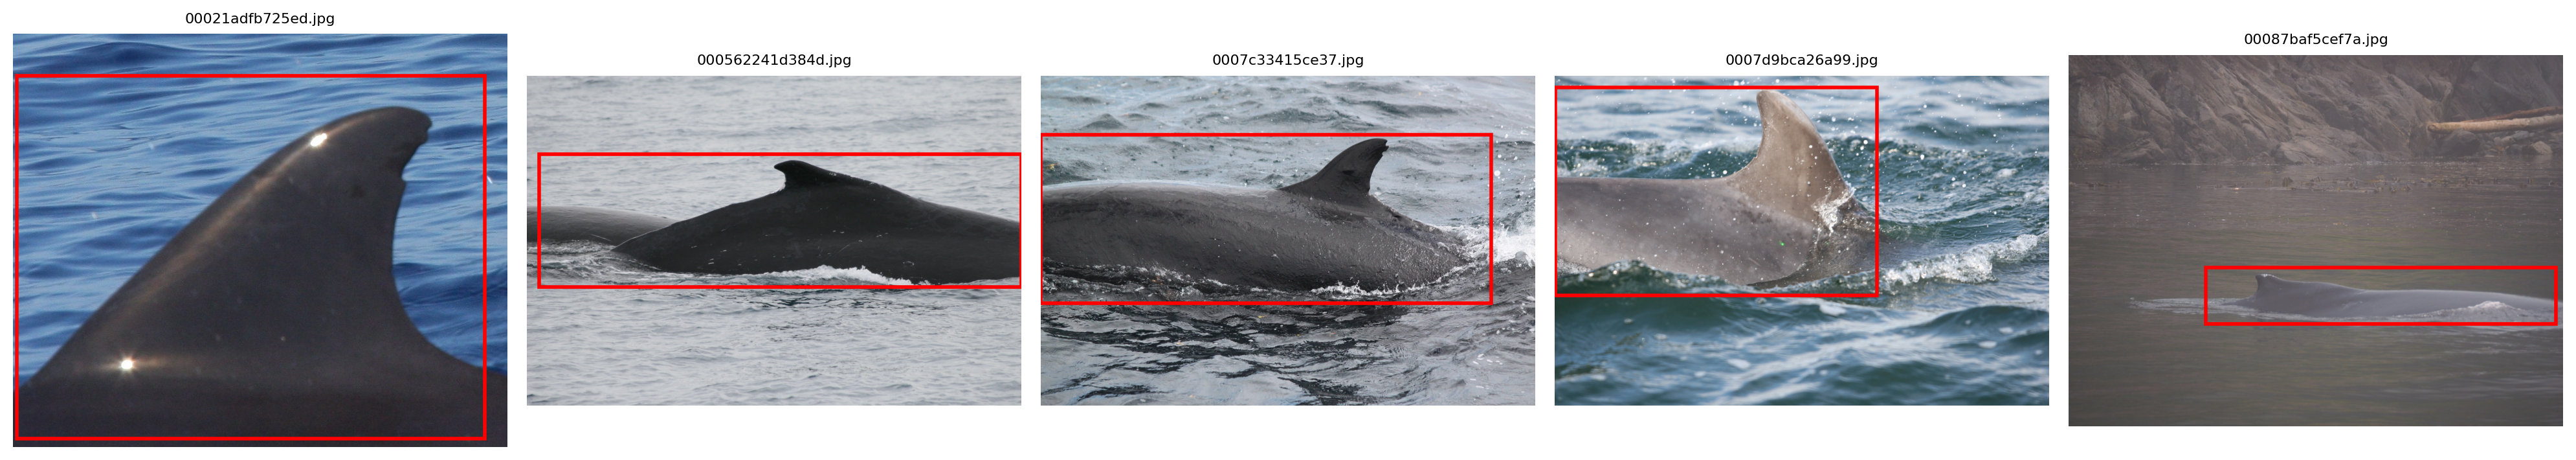

In [3]:
#| echo: false

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.io import decode_image
import os

def visualize_bboxes(image_dir, bbox_csv, n=5):
    df = pd.read_csv(bbox_csv)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    if n == 1: axes = [axes]
    
    for ax, (_, row) in zip(axes, df.head(n).iterrows()):
        img = decode_image(os.path.join(image_dir, row['filename']))
        ax.imshow(img.permute(1, 2, 0))  # CHW -> HWC
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                  linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.set_title(row['filename'], fontsize=8)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
  
visualize_bboxes(
    data_dir + '/train_images',
    'https://raw.githubusercontent.com/philpatton/pyseter/main/data/happywhale-charm-boxes.csv'
)

In [4]:
# #| eval: false

# bbox_url = 'https://raw.githubusercontent.com/philpatton/pyseter/main/data/happywhale-charm-boxes.csv'

# train_dir = data_dir + '/train_images'
# train_features = fe.extract(image_dir=train_dir, bbox_csv=bbox_url)

# # this saves the dictionary as an numpy file
# out_path = feature_dir + '/train_features.npy'
# np.save(out_path, train_features)

# # now do the test images
# test_dir = data_dir + '/test_images'
# test_features = fe.extract(image_dir=test_dir, bbox_csv=bbox_url)

# out_path = feature_dir + '/test_features.npy'
# np.save(out_path, test_features)

If you've already extracted the features, you can load them back into your session.

In [5]:
reference_path = feature_dir + '/train_features.npy'
reference_files, reference_features = load_features(reference_path)

query_path = feature_dir + '/test_features.npy'
query_files, query_features = load_features(query_path)

## Identifying animals

First, we'll create two dictionaries. Dictionaries are similar to a named list in R, where we can access the value in the dictionary by providing it's key. In this case, the key will be the image name and the value will be the feature vector for that image.

We'll also need a `DataFrame` that tells us the identity of every individual in the reference set. This comes with the Kaggle dataset, in the `train.csv` file.

In [6]:
query_dict = dict(zip(query_files, query_features))
reference_dict = dict(zip(reference_files, reference_features))

id_df = pd.read_csv(data_dir + '/train.csv')
id_df.head()

image             species individual_id
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9
1  000562241d384d.jpg      humpback_whale  1a71fbb72250
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b
3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063
4  00087baf5cef7a.jpg      humpback_whale  8e5253662392

And now we're ready to make predictions! By default, `predict_ids` returns 10 proposed IDs. Here we'll show just 2 so for the sake of variety. 

In [7]:
prediction_df = identify.predict_ids(reference_dict, query_dict, id_df, 
                                     proposed_id_count=2)
prediction_df.head(20)

image  rank    predicted_id     score
0   a704da09e32dc3.jpg     1    5f2296c18e26  0.500233
1   a704da09e32dc3.jpg     2  new_individual  0.500000
2   de1569496d42f4.jpg     1    ed237f7c2165  0.826259
3   de1569496d42f4.jpg     2  new_individual  0.500000
4   4ab51dd663dd29.jpg     1    b9b24be2d5ae  0.680653
5   4ab51dd663dd29.jpg     2    31f748b822f4  0.503390
6   da27c3f9f96504.jpg     1    c02b7ad6faa0  0.937102
7   da27c3f9f96504.jpg     2  new_individual  0.500000
8   0df089463bfd6b.jpg     1    f7b322faeeb5  0.538287
9   0df089463bfd6b.jpg     2    ae9cca8f13ca  0.504653
10  813892efb592e0.jpg     1    c22d65f2d2f0  0.808234
11  813892efb592e0.jpg     2  new_individual  0.500000
12  0c9304ddd0ba35.jpg     1    2df99dc71d85  0.852067
13  0c9304ddd0ba35.jpg     2  new_individual  0.500000
14  14718a369776c5.jpg     1    e8d3c0ff0951  0.800375
15  14718a369776c5.jpg     2  new_individual  0.500000
16  65653992318202.jpg     1    c4e546efa5ca  0.842364
17  65653992318202.jpg     2  new_individual  0.500000
18  9857340b9e8c8e.jpg     1    1a20c92ffe68  0.813362
19  9857340b9e8c8e.jpg     2  new_individual  0.500000

By default, `predict_ids` inserts a dummy prediction "new_individual" at 0.5. This makes it easy to evaluate the algorithm with metrics like MAP@5, or calculate the false negative rate. 

You can save the results with `to_csv` from pandas. 

In [8]:
#| eval: false
prediction_df.to_csv('predicted_ids.csv', index=False)

## Updating the reference set

Let's say you've gone through and confirmed all the matches in your query set, e.g., with the [*AnyDorsal* ID app](app.qmd). Now you would like to update your reference set with the new IDs.

Here, we'll take the naive approach that the algorithm's first choice was always correct and update our reference set accordingly.

In [9]:
# select the first match as the correct one
confirmed_matches = prediction_df.loc[prediction_df['rank'] == 1]

Now we'll want to update two things: `id_df`, which contains the true ids for all our reference images, and `reference_features`, which contains the feature vectors for every reference image. To update `id_df`, we need to "union" it (SQL jargon) with the confirmed matches. We do this with `pd.concat()`, which is similar to R's `rbind`. Note that we need to update the column names to do so, and that we don't have the species classification for the individuals in the query set. 

In [10]:
# update the column names
confirmed_match_df = confirmed_matches[['image', 'predicted_id']]
confirmed_match_df.columns = ['image', 'individual_id']

Now we just need to update the 

In [ ]:

def derp(reference_dict, query_dict, confirmed_id_df):
    """Update the reference feature dict with confirmed matches

    Return a dictionary where the keys are the updated reference images and the
    values contain the updated feature array.

    Parameters
    ----------
    reference_dict : dict
        Dictionary where the key is the reference image's name. The value 
        associate with each key is a NumPy array of shape (M, ) where M is the 
        number of features in the feature vector.
    query_dict : dict
        Dictionary where the key is the query image's name. The value 
        associate with each key is a NumPy array of shape (M, ) where M is the 
        number of features in the feature vector.
    id_df : pd.DataFrame
        DataFrame containing the identities, `individual_id`, and image file 
        name, `image`, for every image in the reference set.
    proposed_id_count : integer
        The number of proposed IDs to return for each query image.
    """
    
    # reorder the query_dict to make it match the order of the confirmed_match_df
    confirmed_images = confirmed_id_df.image
    confirmed_feature_dict = {i: query_dict[i] for i in confirmed_images}

    # unpack both dicts 
    reference_features = np.array(list(reference_dict.values()))
    confirmed_features = np.array(list(confirmed_feature_dict.values()))

    # stack the reference features
    print(reference_features.shape)
    print(confirmed_features.shape)
    updated_features = np.hstack((reference_features, confirmed_features))

    # new dict
    reference_images = np.array(list(reference_dict.keys()))
    updated_images = np.concatenate((reference_images, confirmed_images))
    updated_dict = dict(zip(updated_images, updated_features))

    return updated_dict

updated_reference_dict = identify.update_reference_features(
    reference_dict, query_dict, confirmed_match_df
)
out_path = feature_dir + '/updated_features.npy'
np.save(out_path, updated_reference_dict)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 51033 and the array at index 1 has size 27955

In [ ]:

# union with the id_df 
updated_id_df = pd.concat((id_df, confirmed_match_df)).reset_index(drop=True)
updated_id_df.to_csv(data_dir + 'updated_ids.csv', index=False)
updated_id_df.head()